In [2]:
import os 
import numpy as np 
import pandas as pd 
import networkx as nx
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.spatial import distance
from scipy.spatial.distance import pdist
from IPython.display import display, HTML
from scipy.spatial.distance import squareform

In [4]:
PPI_list = pd.read_csv('../../data/pipeline/PPI_reference_barcodes.csv')
PPI_list['PPI_bait'] =  [ PPI_list['PPI'][idx].split('_')[0] for idx in PPI_list.index ]
PPI_list['PPI_prey'] =  [ PPI_list['PPI'][idx].split('_')[1] for idx in PPI_list.index ]

In [5]:
def get_chr(x, gene_loc):
    try :
        return gene_loc[gene_loc['Gene'] == x]['Chromosome_Name'].values[0].replace('CHR', '')
    except :
        return np.nan

def set_correlation_score(idx, table):
    z_score = table['-log_pval'][idx]
    if z_score > 4 : #### Here you can play with this threshold
        return 1
    else :
        return 0

In [6]:
annotated_LDs = pd.read_csv('../../data/genotype_information/snps_annotations_genome-version-3-64-1_LD_annotated.txt').rename(columns={"snp_id":"SNP"})

In [8]:
#### Here I'm building the manhattan similarity matrix across all the conditions
folder_path = '../../data/piQTLs/piQTL_original'
all_MTX = []
MTX_ALL_RESULTS = []
MTX_correlation_matrix = []
for PPI in tqdm(PPI_list['PPI']):
    for DRUG in ['noDrug', '5.FC', 'Fluconazole', 'Metformin', 'Trifluoperazine'] :
        MTX = pd.read_csv(os.path.join(folder_path,f'{PPI}_MTX_{DRUG}_avg_logratio_Fitness_minus_ref.csv'))
        MTX['SNP_ID'] = [ f'CHR{MTX["CHR"][idx]}_{MTX["SNP"][idx]}' for idx in MTX.index ]
        MTX['-log_pval'] = -np.log10(MTX['P'])
        MTX['Condition'] = f'{PPI}_MTX_{DRUG}'
        MTX[f'{PPI}_MTX_{DRUG}'] = [ set_correlation_score(idx, MTX) for idx in MTX.index ]
        all_MTX.append(MTX[MTX.columns[:-1]])
        MTX_correlation_matrix.append(MTX[['SNP_ID', f'{PPI}_MTX_{DRUG}']].set_index(['SNP_ID']).T)

MTX_ALL_RESULTS = pd.concat(all_MTX)
MTX_DF = pd.concat(MTX_correlation_matrix)

100%|██████████| 62/62 [01:08<00:00,  1.11s/it]


In [9]:
#### You need to remove the MTX-specific piQTLs before performing the other steps
MTX_QTLs = pd.read_csv('../../results/05_piQTL_tables/MTX_specific_QTLs_with_genome_annotations.csv')
MTX_QTLs['SNP_ID'] = [ f'CHR{MTX_QTLs["Chr"][idx]}_{MTX_QTLs["SNP"][idx]}' for idx in MTX_QTLs.index ]
MTX_piQTLs = list(MTX_QTLs['SNP_ID'])
MTX_piQTLs.append('CHR15_10435')
MTX_piQTLs.append('CHR15_10455')
MTX_piQTLs.append('CHR15_10456')
MTX_piQTLs.append('CHR15_10468')

In [10]:
ALL_piQTLs = MTX_ALL_RESULTS[(MTX_ALL_RESULTS['-log_pval'] >= 4) & ~(MTX_ALL_RESULTS['SNP_ID'].isin(MTX_piQTLs)) & ~(MTX_ALL_RESULTS['Condition'].str.contains('noPPI_reference'))].reset_index(drop=True)

In [8]:
# ALL_piQTLs = MTX_ALL_RESULTS[(MTX_ALL_RESULTS['-log_pval'] >= 4.4) & ~(MTX_ALL_RESULTS['SNP_ID'].isin(MTX_piQTLs)) & ~(MTX_ALL_RESULTS['Condition'].str.contains('noPPI_reference'))].reset_index(drop=True)
ALL_piQTLs['DRUG'] = [ ALL_piQTLs['Condition'][idx].split('_')[-1] for idx in ALL_piQTLs.index ]

In [9]:
GENE_COORDINATES = pd.read_csv('../data/genome_annotations/sgd_database/orf_coding_R64-3-1.csv')
GENE_COORDINATES['chrom'] = [ GENE_COORDINATES['chrom'][idx].replace('_', '').replace('1000', 'MT') for idx in GENE_COORDINATES.index ]

In [10]:
def get_piQTL_distance(idx):
    BAIT = ALL_piQTLs['Condition'][idx].split('_')[0]
    BAIT_INFO = GENE_COORDINATES[GENE_COORDINATES['name'] == BAIT]
    BAIT_CHR = BAIT_INFO['chrom'].values[0]
    BAIT_START = BAIT_INFO['start'].values[0]
    BAIT_END = BAIT_INFO['end'].values[0]

    PREY = ALL_piQTLs['Condition'][idx].split('_')[1]
    PREY_INFO = GENE_COORDINATES[GENE_COORDINATES['name'] == PREY]
    PREY_CHR = PREY_INFO['chrom'].values[0]
    PREY_START = PREY_INFO['start'].values[0]
    PREY_END = PREY_INFO['end'].values[0]

    SNP_CHR = ALL_piQTLs['SNP_ID'][idx].split('_')[0]
    SNP_POS = ALL_piQTLs['BP'][idx]
    
    if SNP_CHR == BAIT_CHR :
        if (SNP_POS > BAIT_START) & (SNP_POS < BAIT_END):
            return 'cis'
        elif (BAIT_START - SNP_POS < 1000) or (SNP_POS - BAIT_END < 200) :
            return 'cis'
    elif SNP_CHR == PREY_CHR :
        if (SNP_POS > PREY_START) & (SNP_POS < PREY_END):
            return 'cis'
        elif (PREY_START - SNP_POS < 1000) or (SNP_POS - PREY_END < 200) :
            return 'cis'
    else :
        return 'trans'


In [10]:
ALL_piQTLs['cis/trans'] = [ get_piQTL_distance(idx) for idx in ALL_piQTLs.index ]
ALL_piQTLs['cis/trans'] = pd.Categorical(ALL_piQTLs['cis/trans'] , categories=['cis', 'trans'], ordered=True)
ALL_piQTLs['DRUG'] = pd.Categorical(ALL_piQTLs['DRUG'] , categories=['noDrug','Fluconazole','5.FC', 'Metformin', 'Trifluoperazine'], ordered=True)

/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support

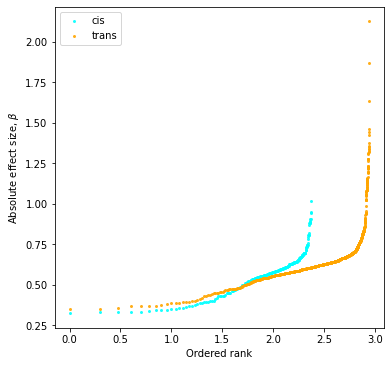

In [12]:
CM = 1/2.54 # centimeters in inches
ALL_piQTLs['abs_Effect'] = np.abs(ALL_piQTLs['EFFECTSIZE'])
f = plt.figure(figsize=(15*CM, 15*CM))
for TYPE in np.unique(ALL_piQTLs['cis/trans']):
    if 'cis' in TYPE :
        color = 'cyan'
    else :
        color= 'orange'
    T = ALL_piQTLs[ALL_piQTLs['cis/trans'] == TYPE].sort_values('abs_Effect', ascending=True).reset_index(drop=True)
    sns.scatterplot(y=T['abs_Effect'], x=np.log10(T.index), marker='.', linewidth=0, alpha = 0.9, color=color)
    plt.ylabel(r'Absolute effect size, $\beta$')
    plt.xlabel('Ordered rank')
    plt.legend(['cis','trans'])
f.savefig('../results/08_piQTL_heatmaps/snp_category/cis_vs_trans_ranked_all_combined.eps', dpi=300)  # ToDo: modify output path

/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getatt

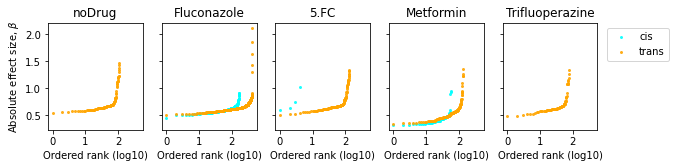

In [13]:
f, axes = plt.subplots(figsize=(25 * CM, 5 * CM), nrows=1, ncols=5, sharey=True, sharex=True)
i = 0
for DRUG in ['noDrug', 'Fluconazole', '5.FC', 'Metformin', 'Trifluoperazine' ]:
    T = ALL_piQTLs[ALL_piQTLs['Condition'].str.contains(DRUG)].reset_index(drop=True)
    T['abs_Effect'] = np.abs(T['EFFECTSIZE'])
    for TYPE in np.unique(T['cis/trans']):
        if 'cis' in TYPE :
            color = 'cyan'
        else :
            color= 'orange'
        TMP = T[T['cis/trans'] == TYPE].sort_values('abs_Effect', ascending=True).reset_index(drop=True)
        sns.scatterplot(y=TMP['abs_Effect'], x=np.log10(TMP.index), marker='.', linewidth=0, alpha = 0.9, color=color, ax=axes[i])
        # axes[i].set_xscale('log')
        axes[i].set_ylabel(r'Absolute effect size, $\beta$')
        axes[i].set_xlabel('Ordered rank (log10)')
        axes[i].set_title(DRUG)
    i += 1

plt.legend(['cis','trans'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
f.savefig('../results/08_piQTL_heatmaps/snp_category/cis_vs_trans_ranked_per_drug_xlog.eps', dpi=300)  # ToDo: modify output path

ks-score:  13.87475232739047 p-value:  1.718474833742665e-40


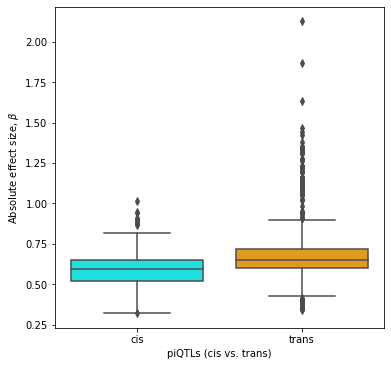

In [14]:
CM = 1/2.54 # centimeters in inches
f = plt.figure(figsize=(15*CM, 15*CM))
sns.boxplot(y=np.abs(ALL_piQTLs['EFFECTSIZE']), x=ALL_piQTLs['cis/trans'], palette=['cyan', 'orange'])
plt.ylabel(r'Absolute effect size, $\beta$')
plt.xlabel('piQTLs (cis vs. trans)')
ks_stat, pval = stats.ttest_ind(ALL_piQTLs[ALL_piQTLs['cis/trans'] == 'cis']['EFFECTSIZE'], ALL_piQTLs[ALL_piQTLs['cis/trans'] == 'trans']['EFFECTSIZE']) 
print('ks-score: ', ks_stat, 'p-value: ', pval)
f.savefig('../results/08_piQTL_heatmaps/snp_category/cis_vs_trans_boxplot_all_combined_V2.eps', dpi=300)  # ToDo: modify output path

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fluconazole ks-statistic:  0.3173041446316566 p-value:  1.8456778463240874e-11
5.FC ks-statistic:  0.3686567164179104 p-value:  0.42311321663448825
Metformin ks-statistic:  0.47109152190821885 p-value:  1.1377708689126457e-08
Trifluoperazine ks-statistic:  0.7051282051282052 p-value:  0.6075949367088608


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


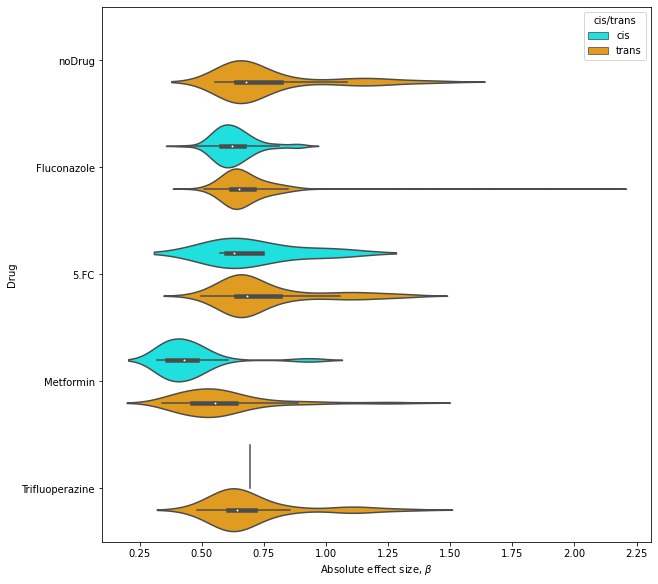

In [15]:
CM = 1/2.54 # centimeters in inches
f = plt.figure(figsize=(25*CM, 25*CM))
sns.violinplot(x=np.abs(ALL_piQTLs['EFFECTSIZE']), y=ALL_piQTLs['DRUG'], hue=ALL_piQTLs['cis/trans'], palette=['cyan', 'orange'])
plt.xlabel(r'Absolute effect size, $\beta$')
plt.ylabel('Drug')
f.savefig('../results/08_piQTL_heatmaps/snp_category/cis_vs_trans_violinplot.eps', dpi=300)  # ToDo: modify output path

for DRUG in ['Fluconazole', '5.FC', 'Metformin', 'Trifluoperazine']:
    ks, pval = stats.kstest(ALL_piQTLs[(ALL_piQTLs['cis/trans'] == 'cis') & (ALL_piQTLs['DRUG'] == DRUG)]['EFFECTSIZE'], ALL_piQTLs[(ALL_piQTLs['cis/trans'] == 'trans') & (ALL_piQTLs['DRUG'] == DRUG)]['EFFECTSIZE'])
    print(DRUG, 'ks-statistic: ', ks, 'p-value: ', pval)

f.savefig('../results/08_piQTL_heatmaps/snp_category/cis_vs_trans_violinplot_all_combined_V2.eps', dpi=300)  # ToDo: modify output path

### Synonymous vs Non-synonymous

In [20]:
synonymous_snps = pd.read_csv('../data/genotype_information/snp_annotations_synonymous.txt').replace('CHR_MT', 'CHRMT')  # ToDo: modify input path
nonsynonymous_snps = pd.read_csv('../data/genotype_information/snp_annotations_non-synonymous.txt').replace('CHR_MT', 'CHRMT')  # ToDo: modify input path
synonymous_snps['SNP_ID'] = [ f'{synonymous_snps["chrom"][idx]}_{synonymous_snps["SNP"][idx]}' for idx in synonymous_snps.index ]
nonsynonymous_snps['SNP_ID'] = [ f'{nonsynonymous_snps["chrom"][idx]}_{nonsynonymous_snps["SNP"][idx]}' for idx in nonsynonymous_snps.index ]
synonymous_snps['SNP_TYPE'] = 'S'
nonsynonymous_snps['SNP_TYPE'] = 'NS'

In [22]:
SNP_TYPE = pd.concat([synonymous_snps, nonsynonymous_snps])

In [34]:
S_vs_NS = MTX_ALL_RESULTS.merge(SNP_TYPE[['SNP_ID', 'SNP_TYPE']], on=['SNP_ID']).reset_index(drop=True)
S_vs_NS['DRUG'] = [ S_vs_NS['Condition'][idx].split('_')[-1] for idx in S_vs_NS.index ]

In [253]:
SvsNS = S_vs_NS[(S_vs_NS['-log_pval'] >= 4.4) & ~(S_vs_NS['SNP_ID'].isin(MTX_piQTLs)) & ~(S_vs_NS['Condition'].str.contains('noPPI_reference'))].reset_index(drop=True)
SvsNS['SNP_TYPE'] = pd.Categorical(SvsNS['SNP_TYPE'] , categories=['S','NS'], ordered=True)
SvsNS['DRUG'] = pd.Categorical(SvsNS['DRUG'] , categories=['noDrug','Fluconazole','5.FC', 'Metformin', 'Trifluoperazine'], ordered=True)

/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support

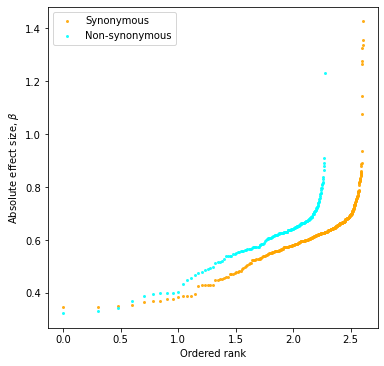

In [340]:
SvsNS['abs_Effect'] = np.abs(SvsNS['EFFECTSIZE'])
f = plt.figure(figsize=(15*CM, 15*CM))
for TYPE in np.unique(SvsNS['SNP_TYPE']):
    if 'S' == TYPE :
        color = 'cyan'
    else :
        color= 'orange'
    T = SvsNS[SvsNS['SNP_TYPE'] == TYPE].sort_values('abs_Effect', ascending=True).reset_index(drop=True)
    sns.scatterplot(y=T['abs_Effect'], x=np.log10(T.index), marker='.', linewidth=0, alpha = 0.9, color=color)
    # plt.xscale('log')
    plt.ylabel(r'Absolute effect size, $\beta$')
    plt.xlabel('Ordered rank')
    plt.legend(['Synonymous','Non-synonymous'])
f.savefig('../results/08_piQTL_heatmaps/snp_category/S_vs_NS_ranked_all_combined.eps', dpi=300)  # ToDO, modify output path

/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/savvy/bin/miniconda3/envs/piQTL/lib/python3.8/site-packages/pandas/core/indexes/base.py:920: RuntimeWarning: divide by zero encountered in log10
  result = getatt

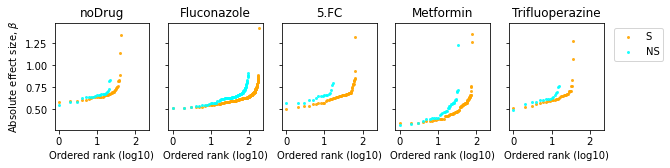

In [327]:
f, axes = plt.subplots(figsize=(25 * CM, 5 * CM), nrows=1, ncols=5, sharey=True, sharex=True)
i = 0
for DRUG in ['noDrug', 'Fluconazole', '5.FC', 'Metformin', 'Trifluoperazine' ]:
    T = SvsNS[SvsNS['Condition'].str.contains(DRUG)].reset_index(drop=True)
    T['abs_Effect'] = np.abs(T['EFFECTSIZE'])
    for TYPE in np.unique(T['SNP_TYPE']):
        if 'S' == TYPE :
            color = 'cyan'
        else : 
            color= 'orange'
        TMP = T[T['SNP_TYPE'] == TYPE].sort_values('abs_Effect', ascending=True).reset_index(drop=True)
        sns.scatterplot(y=TMP['abs_Effect'], x=np.log10(TMP.index), marker='.', linewidth=0, alpha = 0.9, color=color, ax=axes[i])
        # axes[i].set_xscale('log')
        axes[i].set_ylabel(r'Absolute effect size, $\beta$')
        axes[i].set_xlabel('Ordered rank (log10)')
        axes[i].set_title(DRUG)
    i += 1

plt.legend(['S','NS'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
f.savefig('../results/08_piQTL_heatmaps/snp_category/S_vs_NS_ranked_per_drug_xlog.eps', dpi=300)  # ToDo, modify output path

t-test statistic:  -2.097540106663099 p-value:  0.036369949761052636


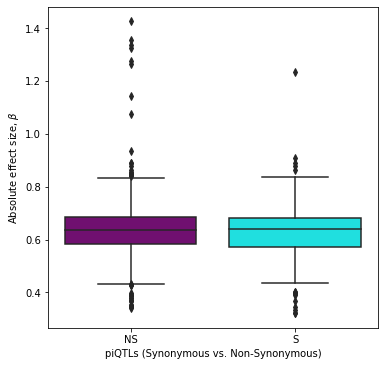

In [239]:
CM = 1/2.54 # centimeters in inches
f = plt.figure(figsize=(15*CM, 15*CM))
sns.boxplot(y=np.abs(SvsNS['EFFECTSIZE']), x=SvsNS['SNP_TYPE'], palette=['purple', 'cyan'])
plt.ylabel(r'Absolute effect size, $\beta$')
plt.xlabel('piQTLs (Synonymous vs. Non-Synonymous)')
ks_stat, pval = stats.ttest_ind(SvsNS[SvsNS['SNP_TYPE'] == 'S']['EFFECTSIZE'],SvsNS[SvsNS['SNP_TYPE'] == 'NS']['EFFECTSIZE'])
print('t-test statistic: ',ks_stat, 'p-value: ', pval)
# f.savefig('../results/08_piQTL_heatmaps/snp_category/S_vs_NS_boxplot_all_combined.eps', dpi=300)  # Todo, modify output path

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


noDrug ks-statistic:  0.1915113871635611 p-value:  0.5686118427532045
Fluconazole ks-statistic:  0.3111111111111111 p-value:  7.278531902051801e-06
5.FC ks-statistic:  0.17676767676767677 p-value:  0.7068039784977936
Metformin ks-statistic:  0.07692307692307693 p-value:  0.9953899217365979
Trifluoperazine ks-statistic:  0.23219814241486067 p-value:  0.47010687302681964


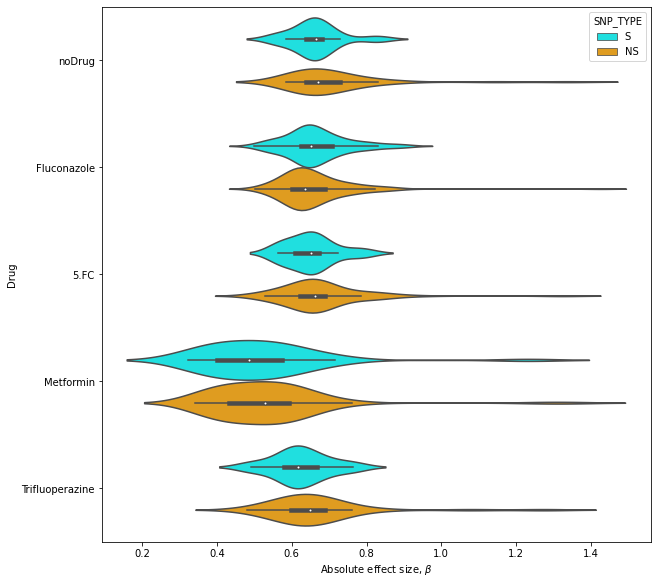

In [254]:
CM = 1/2.54 # centimeters in inches
f = plt.figure(figsize=(25*CM, 25*CM))
sns.violinplot(x=np.abs(SvsNS['EFFECTSIZE']), y=SvsNS['DRUG'], hue=SvsNS['SNP_TYPE'], palette=['cyan', 'orange'])
plt.xlabel(r'Absolute effect size, $\beta$')
plt.ylabel('Drug')
f.savefig('../results/08_piQTL_heatmaps/snp_category/S_vs_NS_violinplot.eps', dpi=300)  # ToDo, modify output path

for DRUG in ['noDrug','Fluconazole', '5.FC', 'Metformin', 'Trifluoperazine']:
    ks, pval = stats.kstest(SvsNS[(SvsNS['SNP_TYPE'] == 'S') & (SvsNS['DRUG'] == DRUG)]['EFFECTSIZE'], SvsNS[(SvsNS['SNP_TYPE'] == 'NS') & (SvsNS['DRUG'] == DRUG)]['EFFECTSIZE'])
    print(DRUG, 'ks-statistic: ', ks, 'p-value: ', pval)

In [89]:
MTX_piQTLs

['CHR15_10448',
 'CHR15_10446',
 'CHR15_10447',
 'CHR15_10445',
 'CHR15_10450',
 'CHR15_10451',
 'CHR15_10453',
 'CHR15_10452',
 'CHR15_10449',
 'CHR15_10459',
 'CHR15_10454',
 'CHR15_10460',
 'CHR15_10462',
 'CHR15_10461',
 'CHR15_10463',
 'CHR15_10466',
 'CHR15_10465',
 'CHR15_10464',
 'CHR15_10467',
 'CHR15_10457',
 'CHR15_10470',
 'CHR15_10469',
 'CHR15_10473',
 'CHR15_10472',
 'CHR15_10471',
 'CHR15_10474',
 'CHR15_10475',
 'CHR15_10444',
 'CHR15_10443',
 'CHR15_10476',
 'CHR15_10477',
 'CHR15_10432',
 'CHR15_10433',
 'CHR15_10442',
 'CHR15_10434',
 'CHR15_10437',
 'CHR15_10478',
 'CHR15_10429',
 'CHR15_10431',
 'CHR15_10430',
 'CHR15_10436',
 'CHR15_10428',
 'CHR15_10435',
 'CHR15_10455',
 'CHR15_10456',
 'CHR15_10468']

In [11]:
piQTL_QTLs = MTX_DF[[ col for col in MTX_DF.columns if col not in list(MTX_piQTLs)]].reset_index().rename(columns={'index':'Condition'})

In [12]:
f = open('./PPI_similarity_network_order.txt', 'r')
PPI_network_order = [ line.strip() for line in f.readlines() ]
f.close()

In [20]:
def get_bin(x):
    if x >=4 :
        return 4
    else :
        return x

def network_distance_vs_overlapping_PPIs(ALL, DRUG1):
    pariwise_comparison_snps = []
    ALL_piQTLs = ALL

    for SNP in tqdm(ALL_piQTLs.columns) :
        for i in range(len(ALL_piQTLs.index)):
            for j in range(i+1, len(ALL_piQTLs.index)):
                PPI1 = ALL_piQTLs.index[i]
                PPI2 = ALL_piQTLs.index[j]

                SNP1 = ALL_piQTLs[SNP][PPI1]
                SNP2 = ALL_piQTLs[SNP][PPI2]
                if SNP1 == SNP2 :
                    if (SNP1 == 0) and (SNP2 == 0):
                        res = 0
                    else :
                        res = 1
                else :
                    res = 0
                pariwise_comparison_snps.append([PPI1.replace(f'_MTX_{DRUG1}', '').replace('_', ':'), PPI2.replace(f'_MTX_{DRUG1}', '').replace('_', ':'), SNP, res])

    results = pd.DataFrame(pariwise_comparison_snps, columns=['PPI1', 'PPI2', 'SNP', 'identity'])
    overlapping_peaks = results.groupby('SNP').sum().reset_index()

    stacked = results.groupby(['PPI1', 'PPI2']).sum().stack()
    PPI_overlapping_peaks = stacked.reset_index().rename(columns={0:'overlapping_peaks'}).drop(columns=['level_2']).sort_values('overlapping_peaks')

    df = pd.read_csv('../../results/07_network_analysis/distance_matrix_piQTLs.csv')

    stacked = df.set_index('PPI').stack()
    PPI_distance = stacked.reset_index().rename(columns={'PPI':'PPI1','level_1':'PPI2', 0:'distance'})
    PPI_distance = PPI_distance[PPI_distance['PPI1'] != PPI_distance['PPI2']]

    RES = PPI_overlapping_peaks.merge(PPI_distance, on=['PPI1', 'PPI2'])
    RES['overlapping_peaks'] = RES['overlapping_peaks'].replace(0,0.5)
    RES['bin'] = RES['distance'].apply(get_bin)


    RES = PPI_overlapping_peaks.merge(PPI_distance, on=['PPI1', 'PPI2'])
    RES['bin'] = RES['distance'].apply(get_bin)

    # RES = RES[RES['overlapping_peaks'] >= 1]

    CM = 1/2.54 # centimeters in inches
    f = plt.figure(figsize=(12*CM, 12*CM))
    sns.violinplot(x=RES['bin'], y=RES['overlapping_peaks'], color='white')
    sns.stripplot(x=RES['bin'], y=RES['overlapping_peaks'], color='black')
    plt.ylabel('Number of overlapping peaks')
    plt.xlabel('Distance on PPI network')
    # plt.yscale('log')
    plt.title(DRUG1)

    # plt.savefig(f'../manuscript/figures/{DRUG1}_PPI_distance_vs_overlapping_piQTLs.png', format='png', dpi=300)
    # plt.savefig(f'../manuscript/figures/{DRUG1}_PPI_distance_vs_overlapping_piQTLs.eps', format='eps', dpi=300)


def get_heatmap(DRUG1, width, height):
    PPI_order_DRUG1 = []
    f = plt.figure(figsize=(width, height))
    if DRUG1 == 'noDrug':
        DRUG2 = 'noDrug'
        for PPI in PPI_network_order:
            if PPI in PPI_list['ppi'].values :
                PPI_order_DRUG1.append(f"{PPI.replace(':','_')}_MTX_{DRUG1}")
            else :
                PPI_order_DRUG1.append(f"{PPI.split(':')[1]}:{PPI.split(':')[0]}_MTX_{DRUG1}".replace(':','_'))

        noDrug = piQTL_QTLs[piQTL_QTLs['Condition'].isin(PPI_order_DRUG1)].reset_index(drop=True)
        noDrug['Condition'] = noDrug['Condition'].astype(pd.CategoricalDtype(ordered=True, categories=PPI_order_DRUG1))
        noDrug = noDrug.sort_values('Condition').set_index('Condition')

        piQTL_only = pd.DataFrame(noDrug.sum(axis=0) != 0, columns=['piQTL']).reset_index('SNP_ID')
        piQTL_only = piQTL_only[piQTL_only['piQTL'] == True]

        sns.heatmap(noDrug[piQTL_only['SNP_ID']], xticklabels=True, yticklabels=True, cmap=['black', 'yellow'], linewidths=0.2, linecolor='gray', cbar=False)
        FINAL_ALL = noDrug[piQTL_only['SNP_ID']]
    else :
        for PPI in PPI_network_order:
            if PPI in PPI_list['ppi'].values :
                PPI_order_DRUG1.append(f"{PPI.replace(':','_')}_MTX_{DRUG1}")
            else :
                PPI_order_DRUG1.append(f"{PPI.split(':')[1]}:{PPI.split(':')[0]}_MTX_{DRUG1}".replace(':','_'))

        Fluc = piQTL_QTLs[piQTL_QTLs['Condition'].isin(PPI_order_DRUG1)].reset_index(drop=True)
        Fluc['Condition'] = Fluc['Condition'].astype(pd.CategoricalDtype(ordered=True, categories=PPI_order_DRUG1))
        Fluc = Fluc.replace(1,2)
        Fluc = Fluc.sort_values('Condition').set_index('Condition')

        DRUG2 = 'noDrug'
        PPI_order_DRUG2 = []
        for PPI in PPI_network_order:
            if PPI in PPI_list['ppi'].values :
                PPI_order_DRUG2.append(f"{PPI.replace(':','_')}_MTX_{DRUG2}")
            else :
                PPI_order_DRUG2.append(f"{PPI.split(':')[1]}:{PPI.split(':')[0]}_MTX_{DRUG2}".replace(':','_'))

        noDrug = piQTL_QTLs[piQTL_QTLs['Condition'].isin(PPI_order_DRUG2)].reset_index(drop=True)
        noDrug['Condition'] = noDrug['Condition'].astype(pd.CategoricalDtype(ordered=True, categories=PPI_order_DRUG2))
        # noDrug = noDrug.replace(1,-1)
        noDrug = noDrug.sort_values('Condition').set_index('Condition')

        Fluc_noDrug = pd.concat([Fluc, noDrug])
        piQTL_only = pd.DataFrame(Fluc_noDrug.sum(axis=0) != 0, columns=['piQTL']).reset_index('SNP_ID')
        piQTL_only = piQTL_only[piQTL_only['piQTL'] == True]


        Fluc_noDrug = Fluc_noDrug.reset_index()

        A = Fluc_noDrug[Fluc_noDrug['Condition'].str.contains(DRUG1)][piQTL_only['SNP_ID']]

        B = Fluc_noDrug[Fluc_noDrug['Condition'].str.contains('noDrug')][piQTL_only['SNP_ID']].reset_index(drop=True)

        ALL = A.add(B)
        ALL.index =  PPI_order_DRUG1
        # ALL.to_csv(f'../results/08_piQTL_heatmaps/{DRUG1}_heatmap.csv')
        # sns.heatmap(ALL, xticklabels=True, yticklabels=True, cmap=['black', 'cyan', 'red', 'green'], linewidths=0.2, linecolor='gray')


        # f.savefig(f'../manuscript/figures/{DRUG1}_heatmap.eps', dpi=300)
        # # g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 7)
        # # g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)

        for SNP in ALL.columns:
            for idx in ALL.index :
                if ALL[SNP][idx] == 1 :
                    ALL[SNP][idx] = 0
                elif ALL[SNP][idx] == 3 :
                    CHR = int(SNP.split('_')[0].replace('CHR',''))
                    ID = int(SNP.split('_')[1])

                    DRUG = pd.read_csv(os.path.join(folder_path,f'{idx}_avg_logratio_Fitness_minus_ref.csv'))
                    NO_DRUG = pd.read_csv(os.path.join(folder_path,f'{idx}_avg_logratio_Fitness_minus_ref.csv'.replace(DRUG1, 'noDrug')))

                    P_Drug = DRUG[(DRUG['CHR'] == CHR) & (DRUG['SNP'] == ID)]['P'].values[0]
                    P_noDrug = NO_DRUG[(NO_DRUG['CHR'] == CHR) & (NO_DRUG['SNP'] == ID)]['P'].values[0]

                    delta = - np.log10(P_Drug) + np.log10(P_noDrug)
                    if delta > 1 :
                        ALL[SNP][idx] = 3
                    else :
                        ALL[SNP][idx] = 0

        piQTL_only_deltaP = pd.DataFrame(ALL.sum(axis=0) != 0, columns=['piQTL']).reset_index('SNP_ID')
        piQTL_only_deltaP = piQTL_only_deltaP[piQTL_only_deltaP['piQTL'] == True]

        sns.heatmap(ALL[piQTL_only_deltaP['SNP_ID']], xticklabels=True, yticklabels=True, cmap=['black', 'black', 'yellow', 'cyan'], linewidths=0.2, linecolor='gray', cbar=False)
        FINAL_ALL = ALL[piQTL_only_deltaP['SNP_ID']]
    # f.savefig(f'../figures/figure_3/{DRUG1}_heatmap_white_background.eps', dpi=300)

    piQTLs_infos = pd.read_csv('../../results/05_piQTL_tables/significant_piQTLs_results_with_genome_annotations_without_MTX_peaks.csv')
    piQTLs_infos['SNP_ID'] = [ f'CHR{piQTLs_infos["Chr"][idx]}_{piQTLs_infos["SNP"][idx]}' for idx in piQTLs_infos.index ]
    significant_piQTLs = piQTLs_infos[piQTLs_infos['FDR'] < 0.05].reset_index(drop=True)
    significant_piQTLs[(significant_piQTLs['Condition'].str.contains(DRUG1))].to_csv(f'../../results/08_piQTL_heatmaps/{DRUG1}_piQTLs_from_heatmap.csv', index=False)

    QTL_RES = significant_piQTLs[(significant_piQTLs['Condition'].str.contains(DRUG1)) & (significant_piQTLs['snps_class_up'].isin(['ORF', 'Promoter', 'Close to 3\'-UTR'])) & (significant_piQTLs['SNP_ID'].isin(FINAL_ALL.columns))].reset_index(drop=True)
    QTL_RES['locus_id'] = [ QTL_RES['locus_id'][idx].replace('_NFR/NDR','') for idx in QTL_RES.index ]
    QTL_RES.sort_values('-log_pval', ascending=False).drop_duplicates(subset='locus_id', keep='first')[['locus_id', 'FDR']].rename(columns={'FDR':DRUG1}).to_csv(f'../../data/safe-data/attributes/all_piQTLs_{DRUG1}.txt', sep='\t', index=False)
    return FINAL_ALL
    # network_distance_vs_overlapping_PPIs(FINAL_ALL, DRUG1)

In [21]:
piQTLs_infos = pd.read_csv('../../results/05_piQTL_tables/significant_piQTLs_results_with_genome_annotations_without_MTX_peaks.csv')
significant_piQTLs = piQTLs_infos[piQTLs_infos['FDR'] < 0.05].reset_index(drop=True)

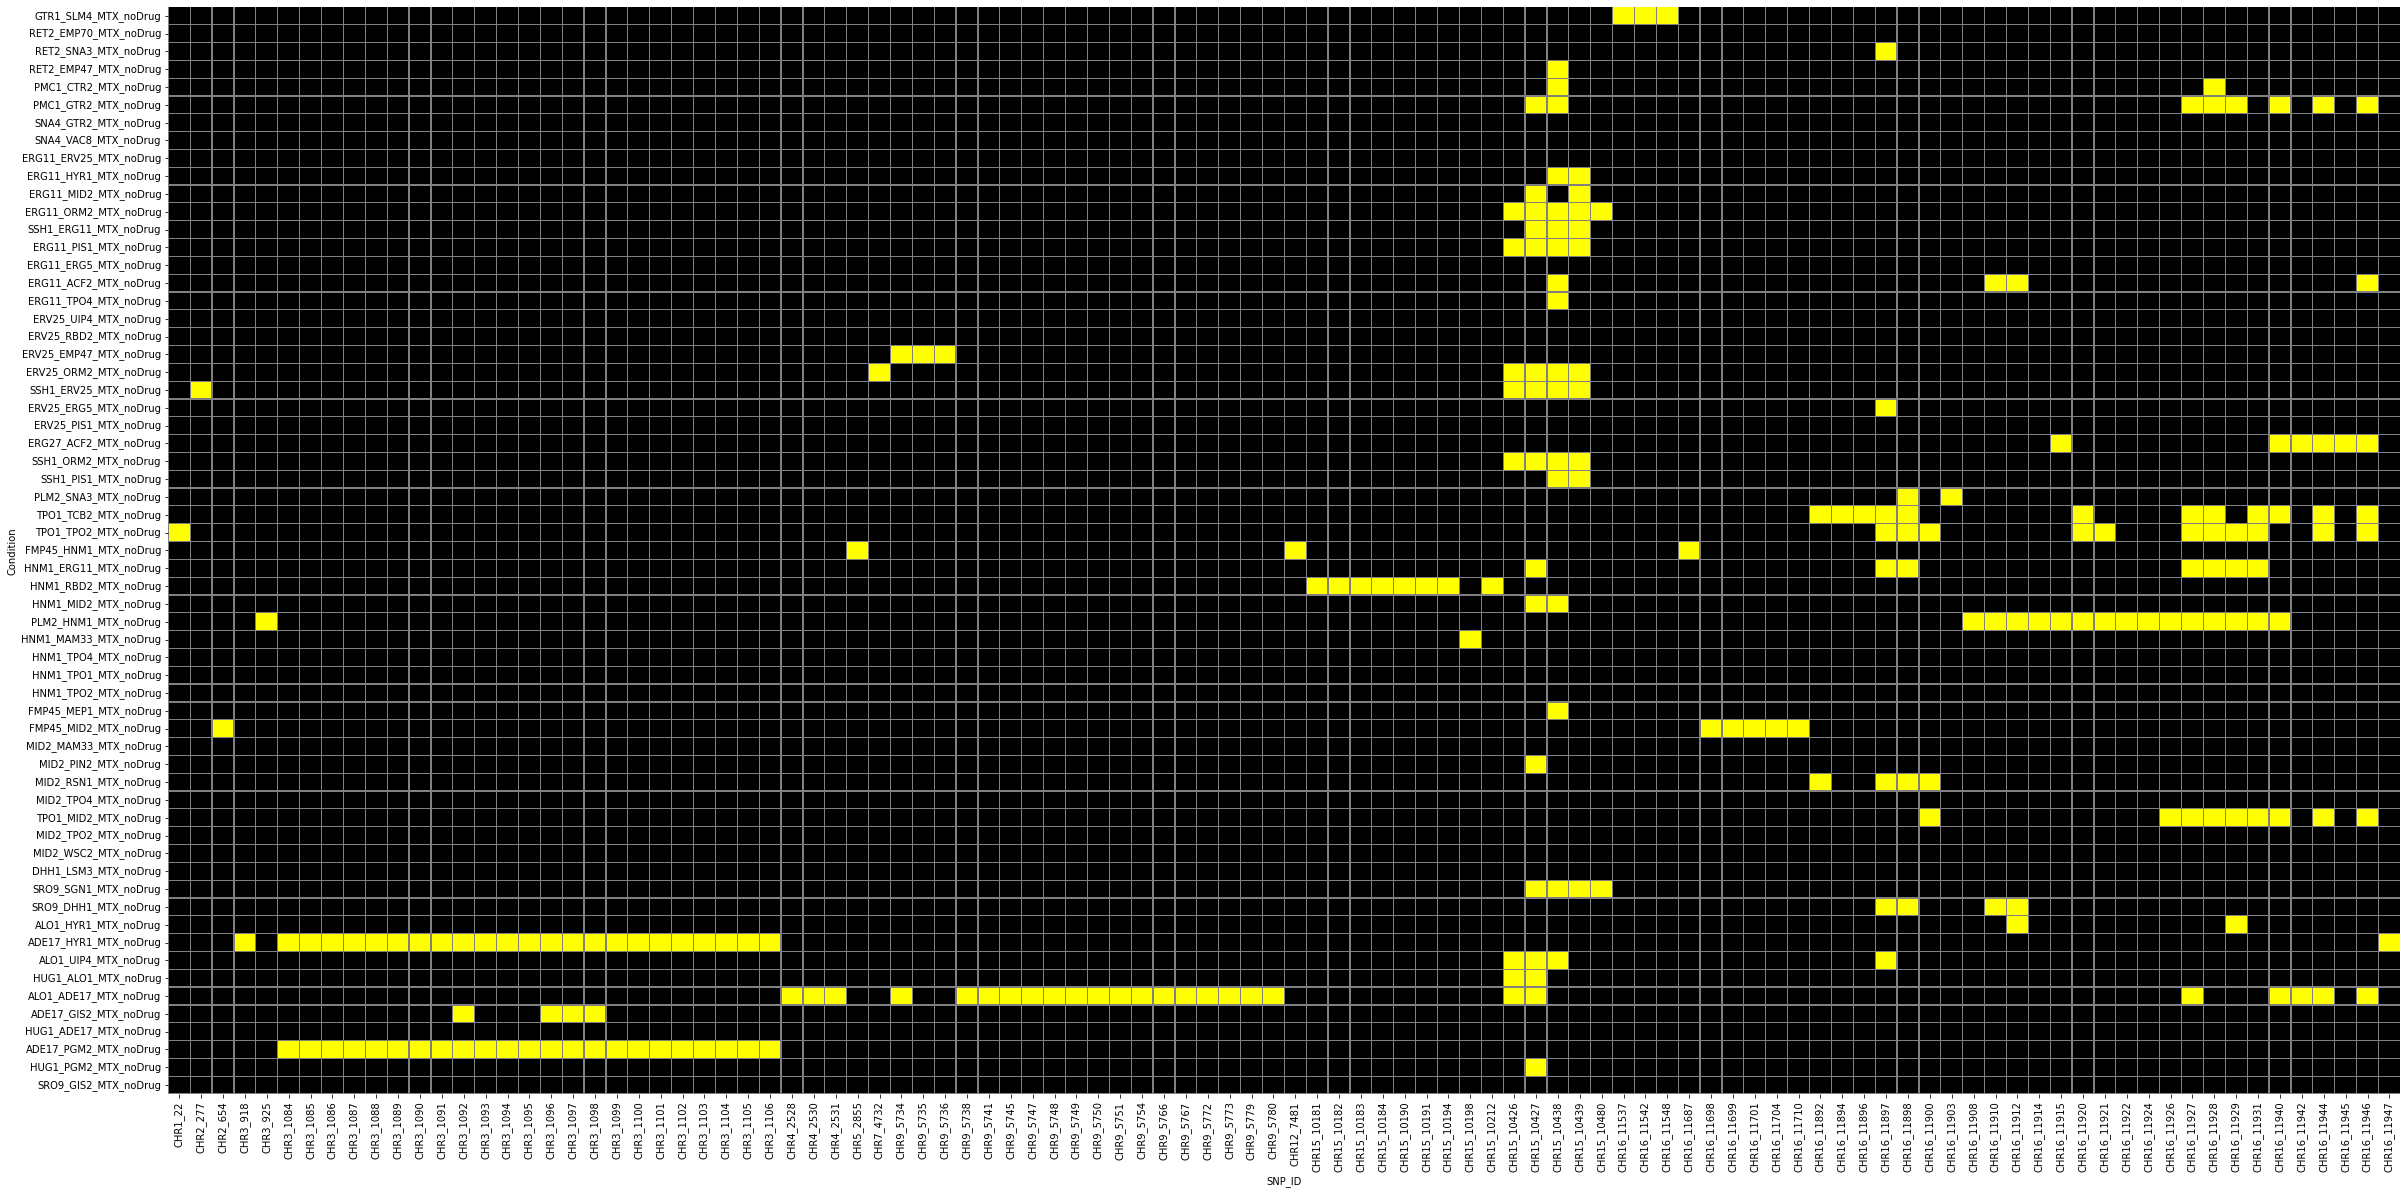

In [22]:
NO_DRUG = get_heatmap('noDrug', 40, 20)

In [56]:
TRANS_NODRUG = NO_DRUG.T

ALL_NODRUG_SNPs = []
for COL in TRANS_NODRUG.columns :
    SNPS = TRANS_NODRUG[TRANS_NODRUG[COL] != 0].index
    for snp in SNPS :
        ALL_NODRUG_SNPs.append(snp)

In [58]:
len(set(ALL_NODRUG_SNPs))

102

In [59]:
piQTLs_infos[(piQTLs_infos['Condition'].str.contains('MTX_noDrug')) & (piQTLs_infos['SNP_ID'].isin(set(ALL_NODRUG_SNPs)).index) & (piQTLs_infos['snps_class_up'] == 'ORF')][['locus_id', 'p-value_rMVP']].sort_values('p-value_rMVP', ascending=False).drop_duplicates(subset='locus_id', keep='last').to_csv('../data/all_piQTLs_noDRUG_for_SAFE.txt', sep='\t', index=False, header=False)

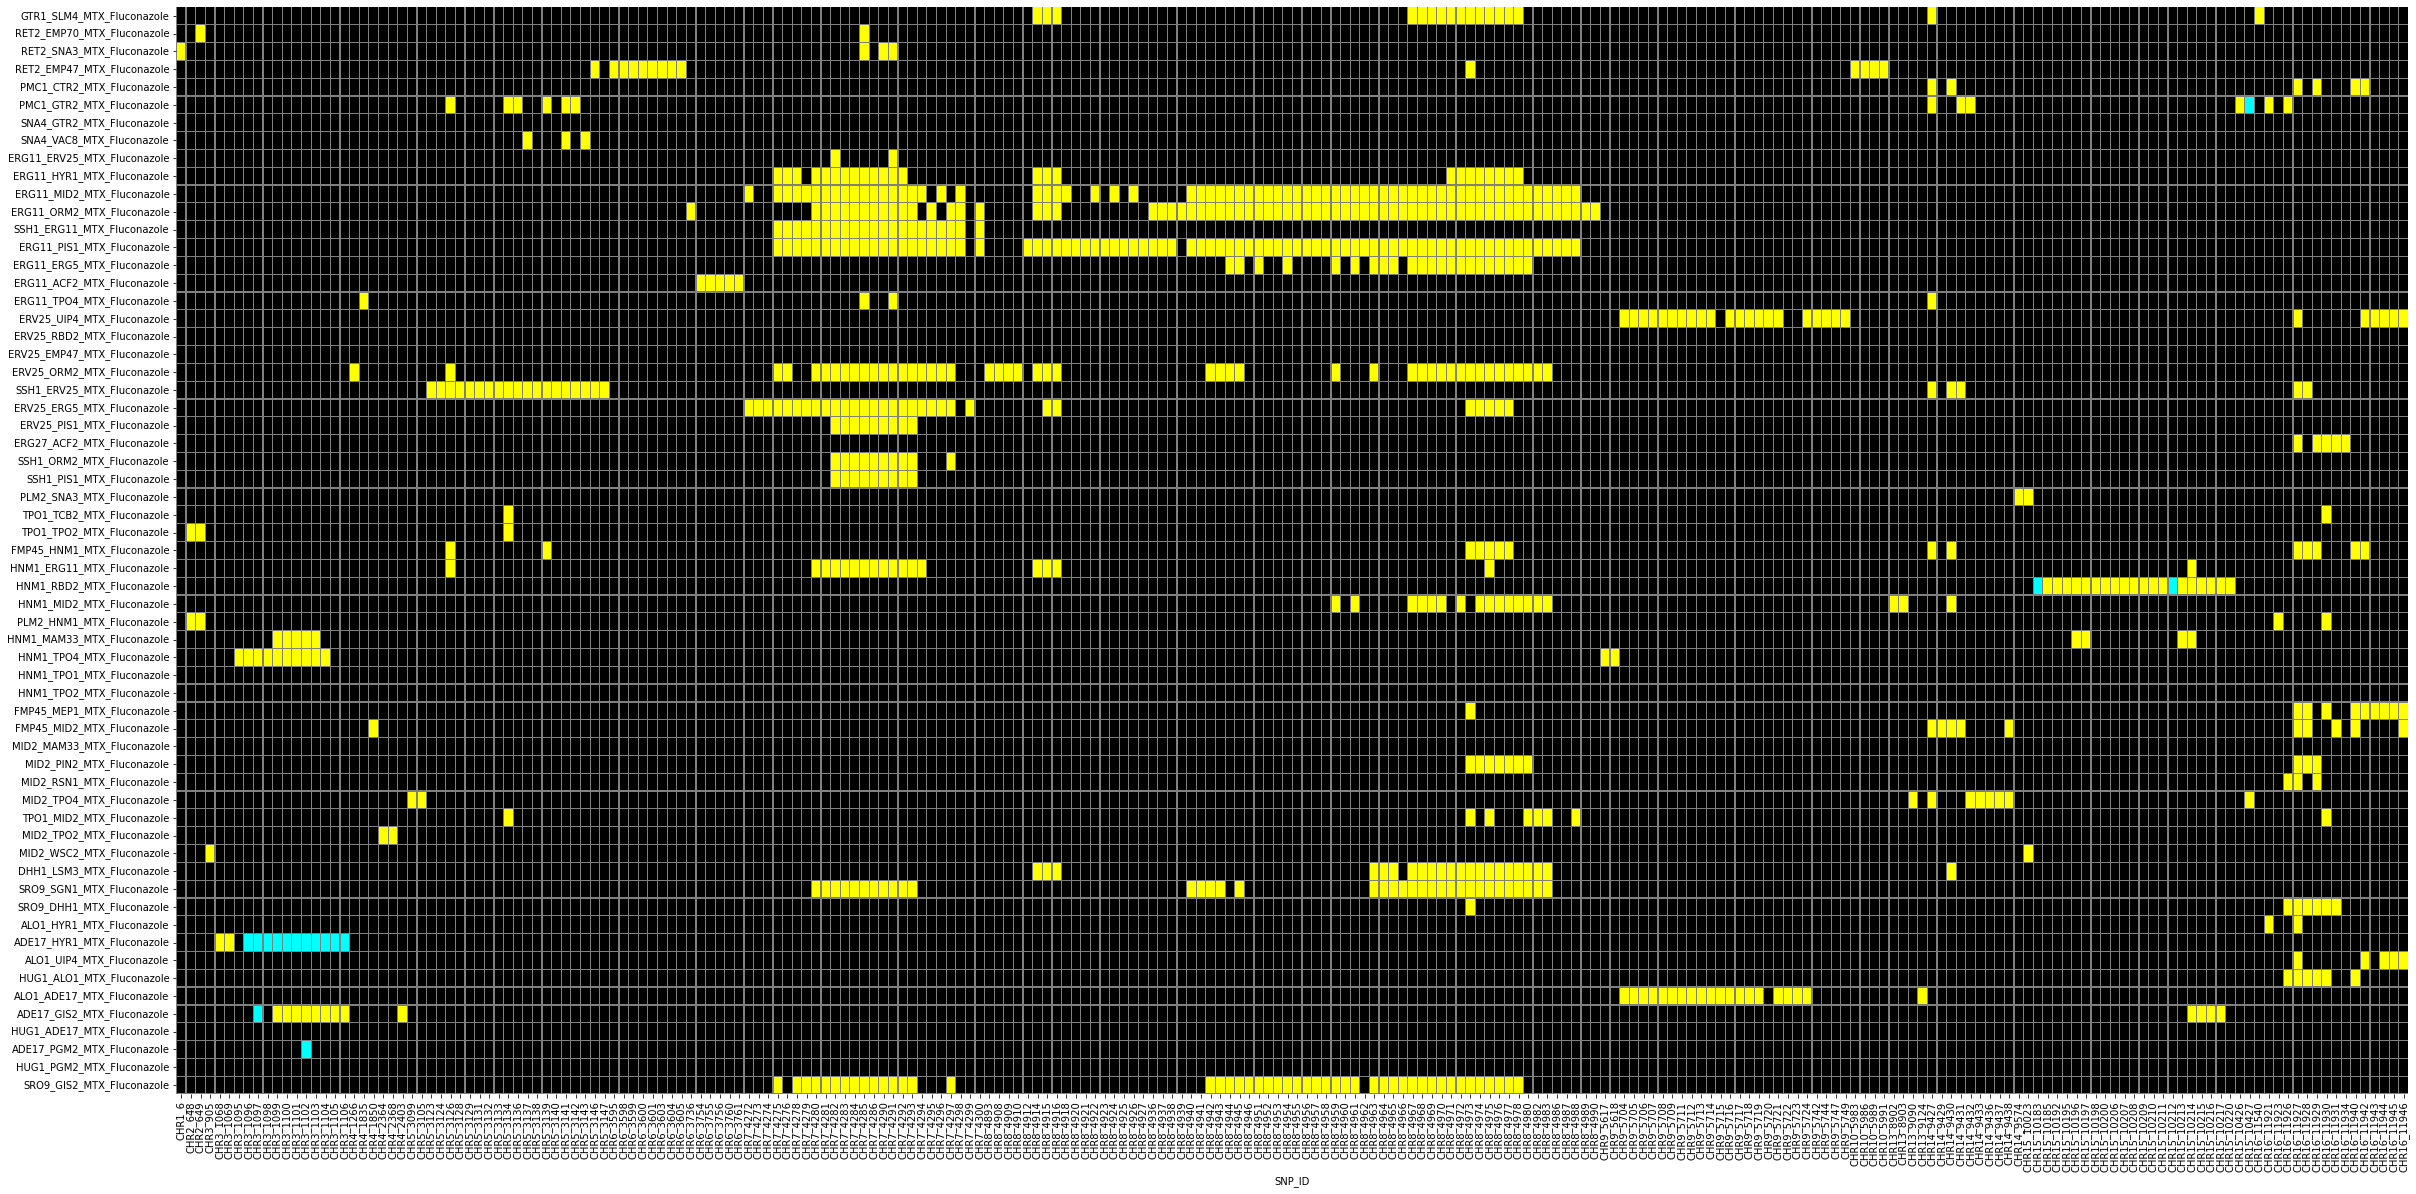

In [23]:
FLUCONAZOLE = get_heatmap('Fluconazole', 40, 20)

In [41]:
FLUCONAZOLE

SNP_ID,CHR1_6,CHR2_648,CHR2_649,CHR3_905,CHR3_1068,CHR3_1069,CHR3_1095,CHR3_1096,CHR3_1097,CHR3_1098,...,CHR16_11929,CHR16_11930,CHR16_11931,CHR16_11934,CHR16_11940,CHR16_11942,CHR16_11943,CHR16_11944,CHR16_11945,CHR16_11946
GTR1_SLM4_MTX_Fluconazole,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RET2_EMP70_MTX_Fluconazole,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RET2_SNA3_MTX_Fluconazole,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RET2_EMP47_MTX_Fluconazole,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PMC1_CTR2_MTX_Fluconazole,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,2,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ADE17_GIS2_MTX_Fluconazole,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
HUG1_ADE17_MTX_Fluconazole,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ADE17_PGM2_MTX_Fluconazole,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HUG1_PGM2_MTX_Fluconazole,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
TRANS_FLUC = FLUCONAZOLE[FLUCONAZOLE.index.str.contains('ERG11_ORM2_MTX_Fluconazole')].T
TRANS_FLUC[TRANS_FLUC['ERG11_ORM2_MTX_Fluconazole'] != 0].index


Index(['CHR6_3736', 'CHR7_4280', 'CHR7_4281', 'CHR7_4282', 'CHR7_4283',
       'CHR7_4284', 'CHR7_4285', 'CHR7_4286', 'CHR7_4290', 'CHR7_4291',
       'CHR7_4292', 'CHR7_4293', 'CHR7_4295', 'CHR7_4297', 'CHR7_4298',
       'CHR7_4300', 'CHR8_4914', 'CHR8_4915', 'CHR8_4916', 'CHR8_4936',
       'CHR8_4937', 'CHR8_4938', 'CHR8_4939', 'CHR8_4940', 'CHR8_4941',
       'CHR8_4942', 'CHR8_4943', 'CHR8_4944', 'CHR8_4945', 'CHR8_4946',
       'CHR8_4951', 'CHR8_4952', 'CHR8_4953', 'CHR8_4954', 'CHR8_4955',
       'CHR8_4956', 'CHR8_4957', 'CHR8_4958', 'CHR8_4959', 'CHR8_4960',
       'CHR8_4961', 'CHR8_4962', 'CHR8_4963', 'CHR8_4964', 'CHR8_4965',
       'CHR8_4966', 'CHR8_4967', 'CHR8_4968', 'CHR8_4969', 'CHR8_4970',
       'CHR8_4971', 'CHR8_4972', 'CHR8_4973', 'CHR8_4974', 'CHR8_4975',
       'CHR8_4976', 'CHR8_4977', 'CHR8_4978', 'CHR8_4980', 'CHR8_4982',
       'CHR8_4983', 'CHR8_4986', 'CHR8_4987', 'CHR8_4988', 'CHR8_4989',
       'CHR8_4990'],
      dtype='object', name='SNP_ID')

In [28]:
piQTLs_infos[(piQTLs_infos['Condition']=='ERG11_ORM2_MTX_Fluconazole') & (piQTLs_infos['SNP_ID']).isin(TRANS_FLUC[TRANS_FLUC['ERG11_ORM2_MTX_Fluconazole'] != 0].index) & (piQTLs_infos['snps_class_up'] == 'ORF')][['locus_id', 'p-value_rMVP']].sort_values('p-value_rMVP', ascending=False).drop_duplicates(subset='locus_id', keep='last').to_csv('../../data/safe-data/attributes/ERG11_ORM2_Fluconazole.txt', sep='\t', index=False)

In [50]:
TRANS_FLUC = FLUCONAZOLE.T

ALL_FLUC_SNPs = []
for COL in TRANS_FLUC.columns :
    SNPS = TRANS_FLUC[TRANS_FLUC[COL] != 0].index
    for snp in SNPS :
        ALL_FLUC_SNPs.append(snp)

In [51]:
len(set(ALL_FLUC_SNPs))

232

In [55]:
piQTLs_infos[(piQTLs_infos['Condition'].str.contains('MTX_Fluconazole')) & (piQTLs_infos['SNP_ID'].isin(set(ALL_FLUC_SNPs)).index) & (piQTLs_infos['snps_class_up'] == 'ORF')][['locus_id', 'p-value_rMVP']].sort_values('p-value_rMVP', ascending=False).drop_duplicates(subset='locus_id', keep='last').to_csv('../data/all_piQTLs_Fluconazole_for_SAFE.txt', sep='\t', index=False, header=False)

In [45]:
GWAS_SUBSET = pd.read_csv('../data/gwas_results/Fluconazole_pval_results.txt', sep='\t')
GWAS_SUBSET = GWAS_SUBSET[GWAS_SUBSET['gene'] == '36h-Fluconazole']
GWAS_SUBSET = GWAS_SUBSET.merge(annotated_LDs[['SNP', 'LD_block']]).sort_values('FDR').drop_duplicates(subset='LD_block', keep='first')

In [46]:
GWAS_SUBSET_SNPs = GWAS_SUBSET[-np.log10(GWAS_SUBSET['p-value']) > 4]['SNP'].values

In [48]:
GWAS_ALL = pd.read_csv('../data/gwas_results/Fluconazole_pval_results_full_GWAS.txt', sep='\t')
GWAS_ALL = GWAS_ALL[GWAS_ALL['gene'] == '36h-Fluconazole']
GWAS_ALL = GWAS_ALL.merge(annotated_LDs[['SNP', 'LD_block']]).sort_values('FDR').drop_duplicates(subset='LD_block', keep='first')

In [49]:
GWAS_ALL_SNPs = GWAS_ALL[-np.log10(GWAS_ALL['p-value']) > 4]['SNP'].values

In [75]:
INDPT_SNPs = ALL_piQTLs[ALL_piQTLs['Condition'].str.contains('Fluconazole')].merge(annotated_LDs[['SNP', 'LD_block']]).sort_values('P').drop_duplicates(subset='LD_block', keep='first')

In [83]:
FLUCONAZOLE_SNPs = [ int(SNP.split('_')[1]) for SNP in FLUCONAZOLE.columns.values if int(SNP.split('_')[1]) in INDPT_SNPs['SNP'].values.tolist() ]

In [84]:
set(GWAS_ALL_SNPs) & set(GWAS_SUBSET_SNPs) & set(FLUCONAZOLE_SNPs)

{4912, 4962, 4973, 4974, 4975}

In [85]:
from matplotlib_venn import venn3

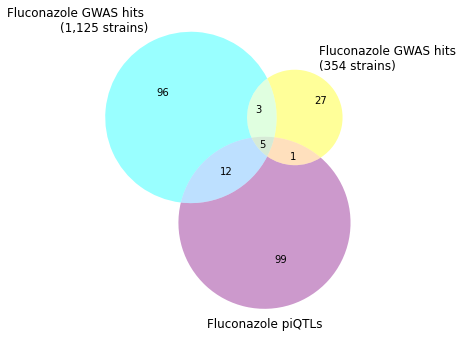

In [86]:
CM = 1/2.54 # centimeters in inches

f = plt.figure(figsize=(20*CM, 15*CM))
out = venn3([set(GWAS_ALL_SNPs), set(GWAS_SUBSET_SNPs), set(FLUCONAZOLE_SNPs) ], set_colors =('cyan','yellow', 'purple'), set_labels=['Fluconazole GWAS hits \n(1,125 strains)', 'Fluconazole GWAS hits \n(354 strains)', 'Fluconazole piQTLs'])
plt.show() 
# f.savefig('../results/08_piQTL_heatmaps/Fluconazole_GWAS_vs_piQTLs_overlap.eps', dpi=300, format='eps')  # ToDo, modify output path

In [127]:
piQTLs_infos[piQTLs_infos['SNP_ID'] == 'CHR8_4975']

,SNP,Condition,beta,t-stat,p-value_eQTL,FDR,Chr,Pos,Effect,SE,...,locus_id,name,sgd_id,snps_class_up,snps_class_down,description,genome_annotations,SNP_ID,-log_pval,QTLs
2,4975,ERG11_PIS1_MTX_Fluconazole,0.879268,7.073718,8.081820e-12,1.012223e-08,8,122207,0.879268,0.124633,...,SUT153,NaN,NaN,Unstable transcript,SUT,ncRNA_UNB,Unstable transcript,CHR8_4975,11.037061,1
12,4975,ERG11_MID2_MTX_Fluconazole,0.809558,6.803798,4.344900e-11,5.108799e-08,8,122207,0.809558,0.119308,...,SUT153,NaN,NaN,Unstable transcript,SUT,ncRNA_UNB,Unstable transcript,CHR8_4975,10.309771,1
29,4975,ERG11_ORM2_MTX_Fluconazole,0.738767,6.317190,7.975253e-10,8.395956e-07,8,122207,0.738767,0.117224,...,SUT153,NaN,NaN,Unstable transcript,SUT,ncRNA_UNB,Unstable transcript,CHR8_4975,9.057869,1
153,4975,ERG11_ERG5_MTX_Fluconazole,0.632843,5.255132,2.557847e-07,2.021362e-04,8,122207,0.632843,0.120689,...,SUT153,NaN,NaN,Unstable transcript,SUT,ncRNA_UNB,Unstable transcript,CHR8_4975,6.565548,1
318,4975,SRO9_GIS2_MTX_Fluconazole,0.598752,4.914040,1.365090e-06,9.679290e-04,8,122207,0.598752,0.122077,...,SUT153,NaN,NaN,Unstable transcript,SUT,ncRNA_UNB,Unstable transcript,CHR8_4975,5.844474,1
400,4975,ERV25_ORM2_MTX_Fluconazole,0.703477,4.761708,2.800774e-06,1.883731e-03,8,122207,0.703477,0.148029,...,SUT153,NaN,NaN,Unstable transcript,SUT,ncRNA_UNB,Unstable transcript,CHR8_4975,5.532820,1
522,4975,DHH1_LSM3_MTX_Fluconazole,0.687830,4.617340,5.441721e-06,3.448829e-03,8,122207,0.687830,0.149185,...,SUT153,NaN,NaN,Unstable transcript,SUT,ncRNA_UNB,Unstable transcript,CHR8_4975,5.250120,1
571,4975,SRO9_SGN1_MTX_Fluconazole,0.601093,4.560067,7.049801e-06,4.384302e-03,8,122207,0.601093,0.132031,...,SUT153,NaN,NaN,Unstable transcript,SUT,ncRNA_UNB,Unstable transcript,CHR8_4975,5.136621,1
583,4975,HNM1_MID2_MTX_Fluconazole,0.619617,4.543190,7.604915e-06,4.696848e-03,8,122207,0.619617,0.136755,...,SUT153,NaN,NaN,Unstable transcript,SUT,ncRNA_UNB,Unstable transcript,CHR8_4975,5.094157,1
611,4975,ERG11_HYR1_MTX_Fluconazole,0.578604,4.521384,8.384515e-06,5.134505e-03,8,122207,0.578604,0.128269,...,SUT153,NaN,NaN,Unstable transcript,SUT,ncRNA_UNB,Unstable transcript,CHR8_4975,5.055399,1


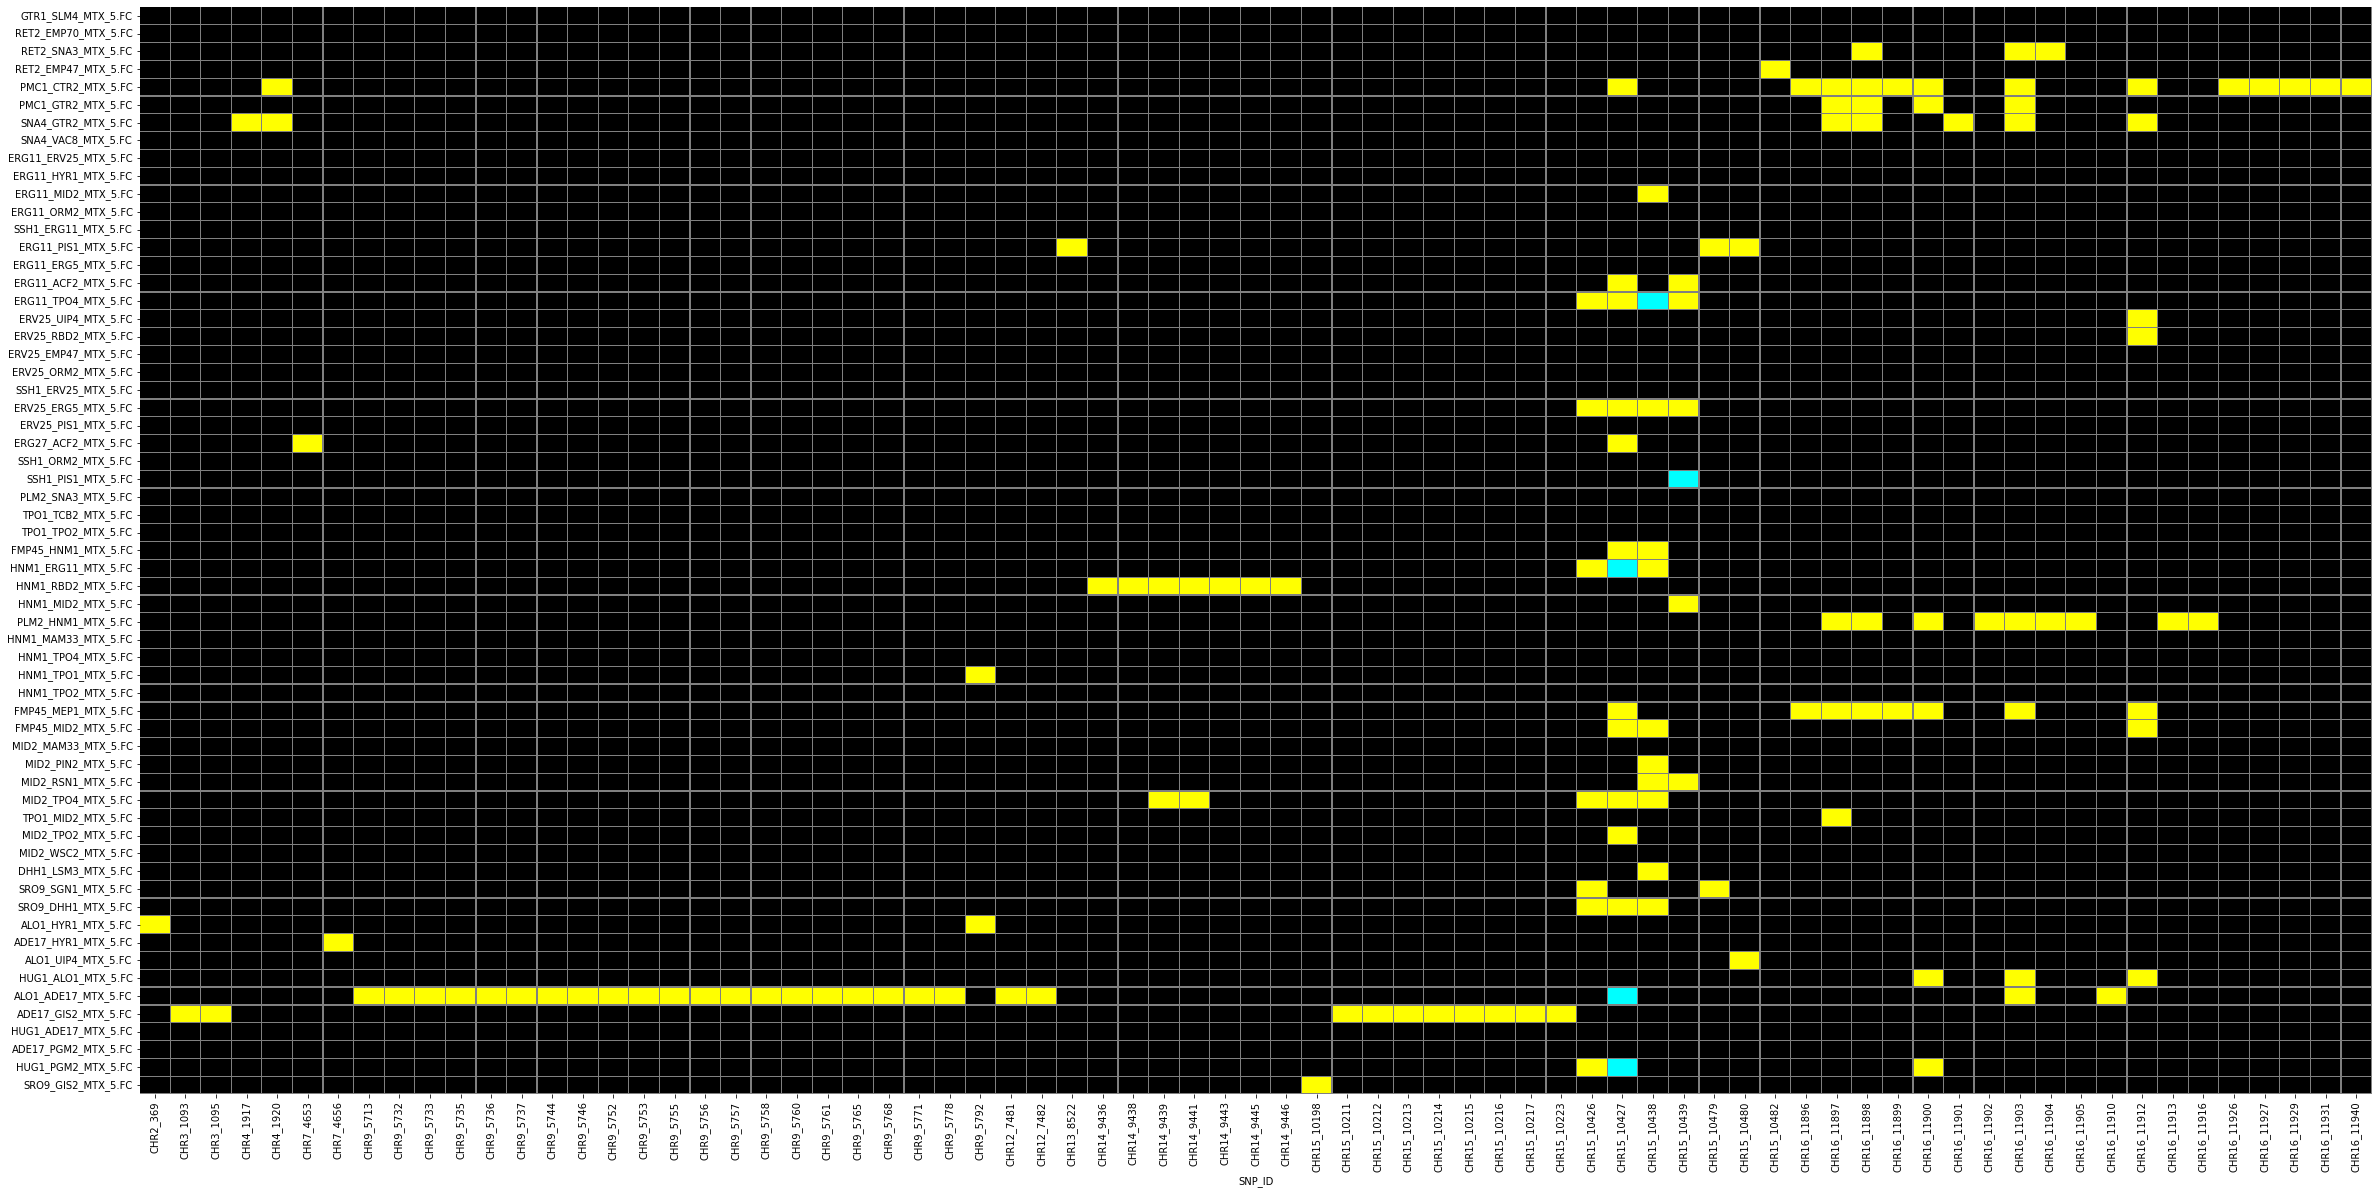

In [29]:
FFC = get_heatmap('5.FC', 40, 20)

In [69]:
TRANS_FFC = FFC.T

ALL_FFC_SNPs = []
for COL in TRANS_FFC.columns :
    SNPS = TRANS_FFC[TRANS_FFC[COL] != 0].index
    for snp in SNPS :
        ALL_FFC_SNPs.append(snp)

In [70]:
len(set(ALL_FFC_SNPs))

73

In [71]:
piQTLs_infos[(piQTLs_infos['Condition'].str.contains('MTX_Fluconazole')) & (piQTLs_infos['SNP_ID'].isin(set(ALL_FFC_SNPs)).index) & (piQTLs_infos['snps_class_up'] == 'ORF')][['locus_id', 'p-value_rMVP']].sort_values('p-value_rMVP', ascending=False).drop_duplicates(subset='locus_id', keep='last').to_csv('../data/all_piQTLs_5-FC_for_SAFE.txt', sep='\t', index=False, header=False)  # ToDo, modify output path

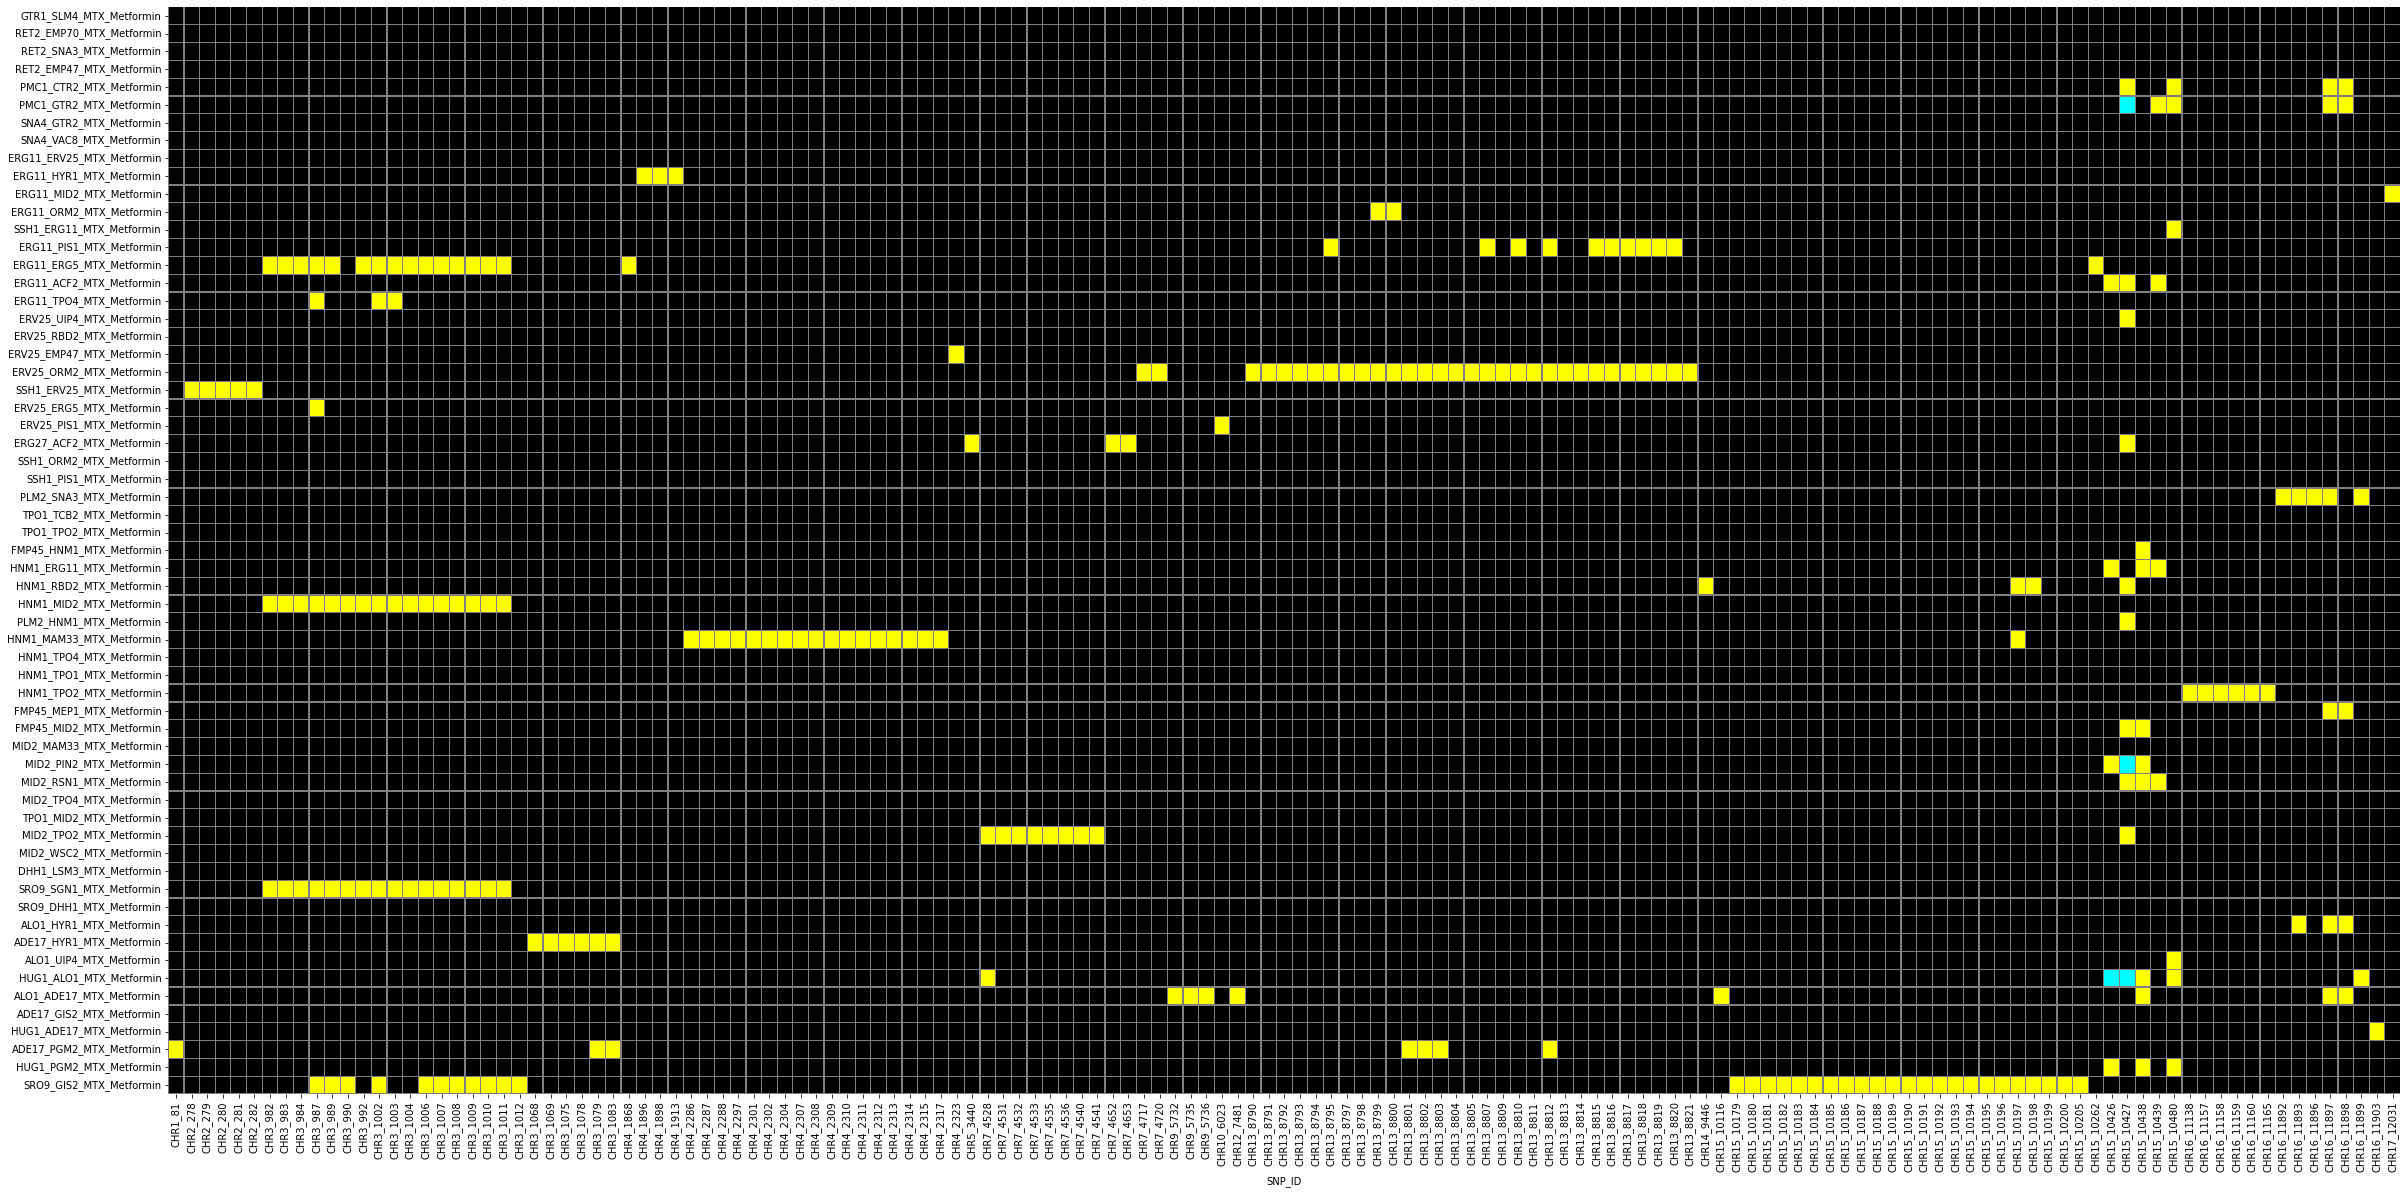

In [24]:
METFORMIN = get_heatmap('Metformin', 40, 20)

In [73]:
TRANS_METFORMIN = METFORMIN.T

ALL_METF_SNPs = []
for COL in TRANS_METFORMIN.columns :
    SNPS = TRANS_METFORMIN[TRANS_METFORMIN[COL] != 0].index
    for snp in SNPS :
        ALL_METF_SNPs.append(snp)

In [74]:
len(set(ALL_METF_SNPs))

143

In [75]:
piQTLs_infos[(piQTLs_infos['Condition'].str.contains('MTX_Fluconazole')) & (piQTLs_infos['SNP_ID'].isin(set(ALL_METF_SNPs)).index) & (piQTLs_infos['snps_class_up'] == 'ORF')][['locus_id', 'p-value_rMVP']].sort_values('p-value_rMVP', ascending=False).drop_duplicates(subset='locus_id', keep='last').to_csv('../data/all_piQTLs_Metformin_for_SAFE.txt', sep='\t', index=False, header=False)  # ToDo, modify output path

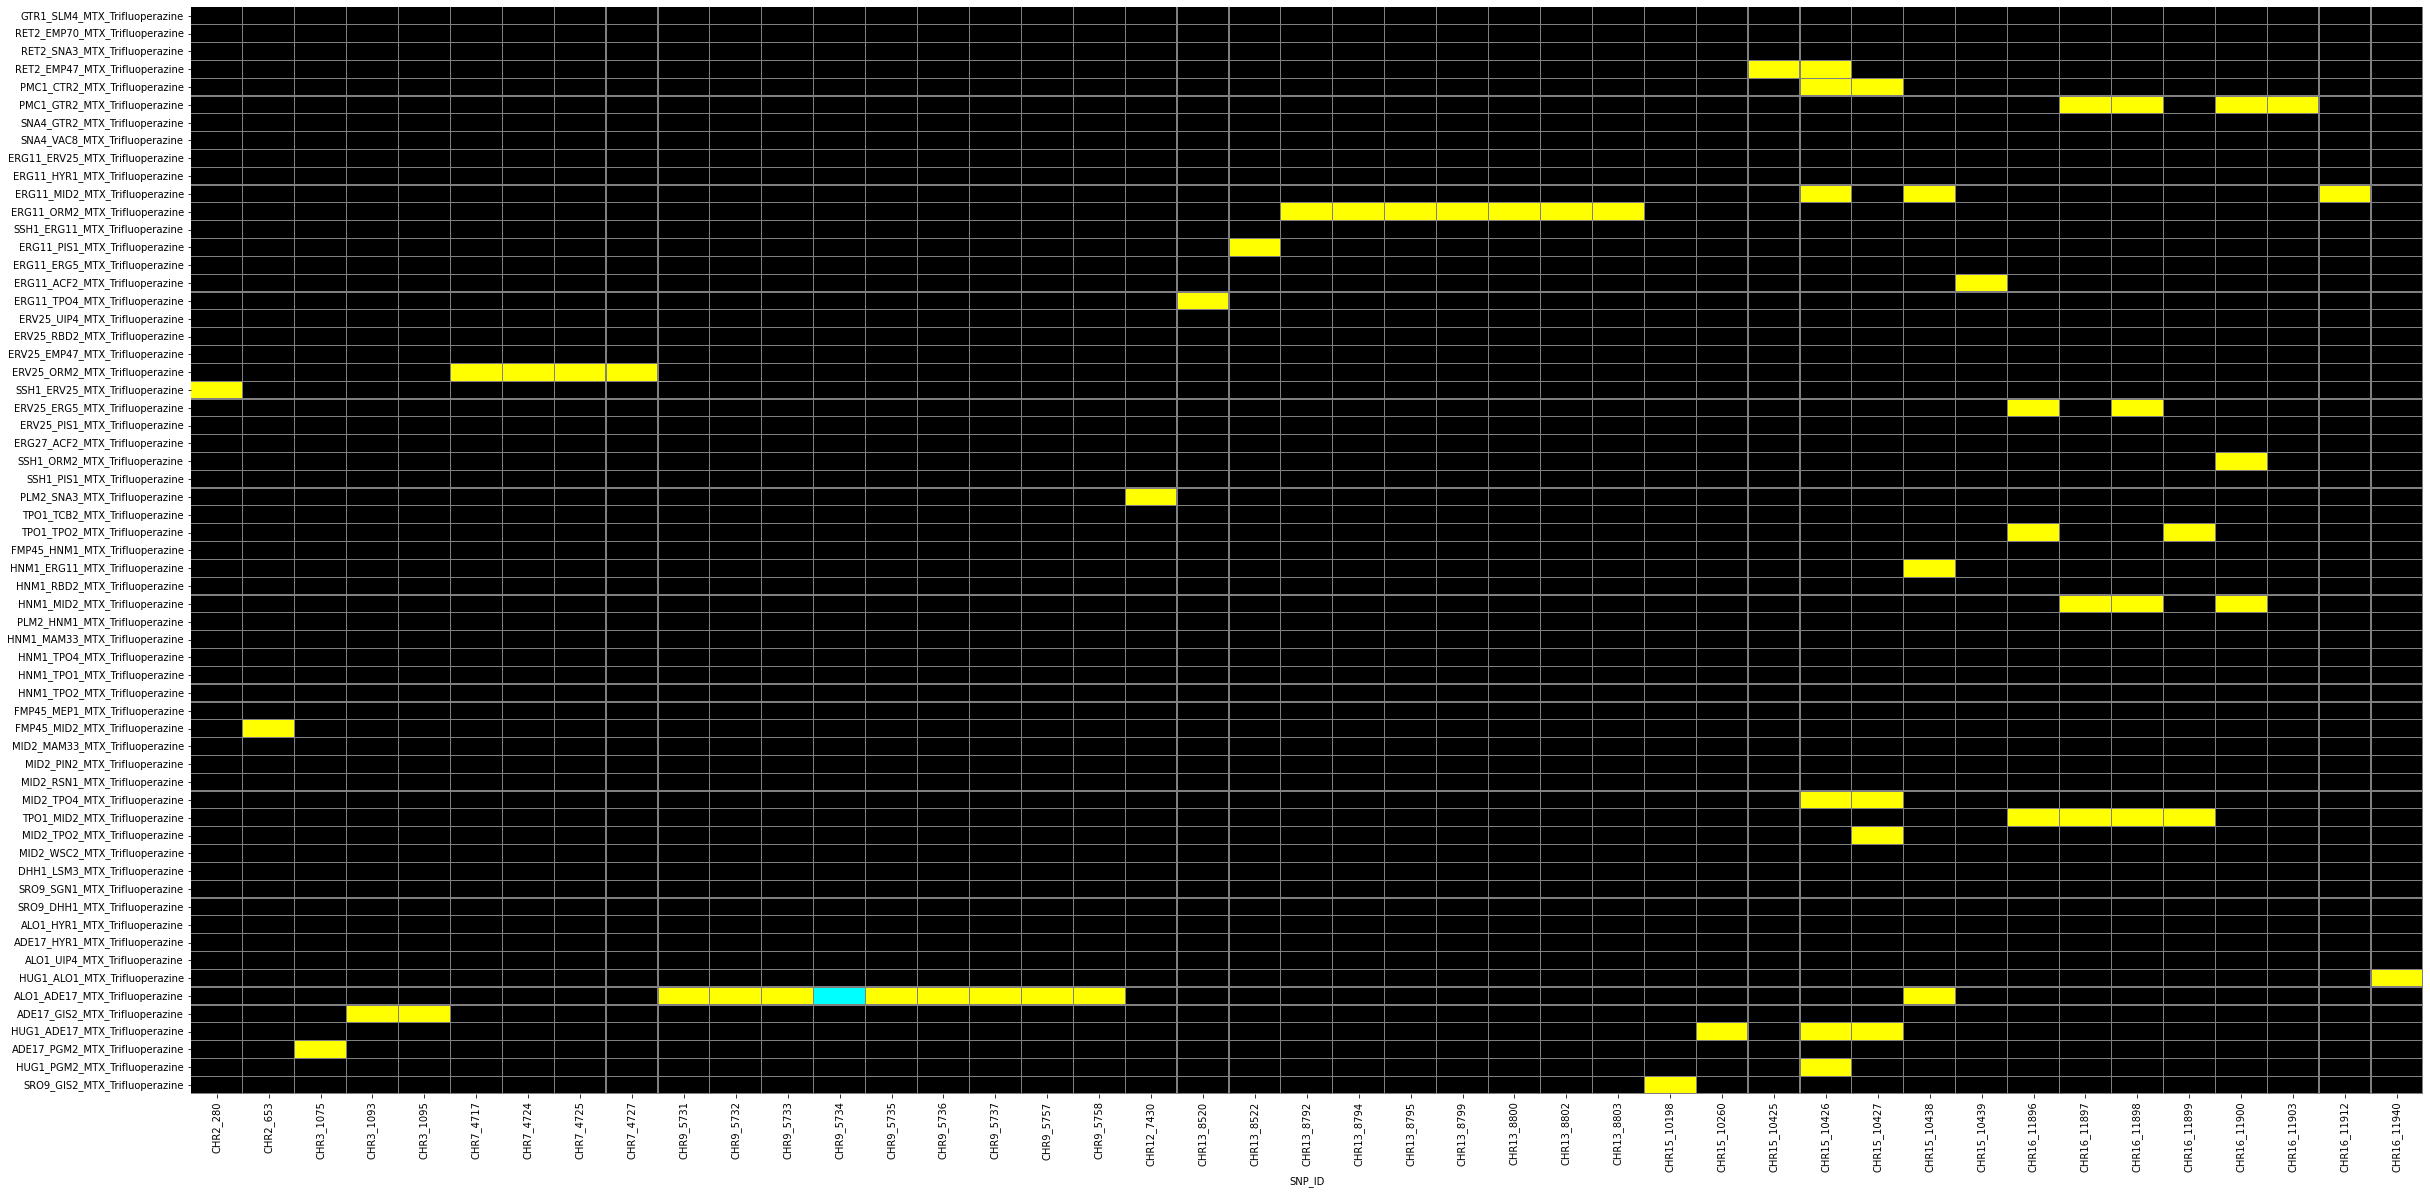

In [25]:
TRIFLUOPERAZINE = get_heatmap('Trifluoperazine', 40, 20)

In [77]:
TRANS_TRIFLUOPERAZINE = TRIFLUOPERAZINE.T

ALL_TRIFL_SNPs = []
for COL in TRANS_TRIFLUOPERAZINE.columns :
    SNPS = TRANS_TRIFLUOPERAZINE[TRANS_TRIFLUOPERAZINE[COL] != 0].index
    for snp in SNPS :
        ALL_TRIFL_SNPs.append(snp)

In [78]:
len(set(ALL_TRIFL_SNPs))

43

In [79]:
piQTLs_infos[(piQTLs_infos['Condition'].str.contains('MTX_Trifluoperazine')) & (piQTLs_infos['SNP_ID'].isin(set(ALL_TRIFL_SNPs)).index) & (piQTLs_infos['snps_class_up'] == 'ORF')][['locus_id', 'p-value_rMVP']].sort_values('p-value_rMVP', ascending=False).drop_duplicates(subset='locus_id', keep='last').to_csv('../data/all_piQTLs_Trifluoperazine_for_SAFE.txt', sep='\t', index=False, header=False)  # ToDo: modify output path